In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

# Get the current research's directory
research_dir = os.path.dirname(os.path.abspath('__file__'))

# Move one directory back
parent_dir = os.path.dirname(research_dir)

# Change the current working directory to the parent directory
os.chdir(parent_dir)

# Print the current working directory to confirm
print(f"Current working directory: {os.getcwd()}")

In [ ]:
from frank.utils.common import print_process_astream

# Unstructured Adaptative RAG implementation

## MultiVector Retriever

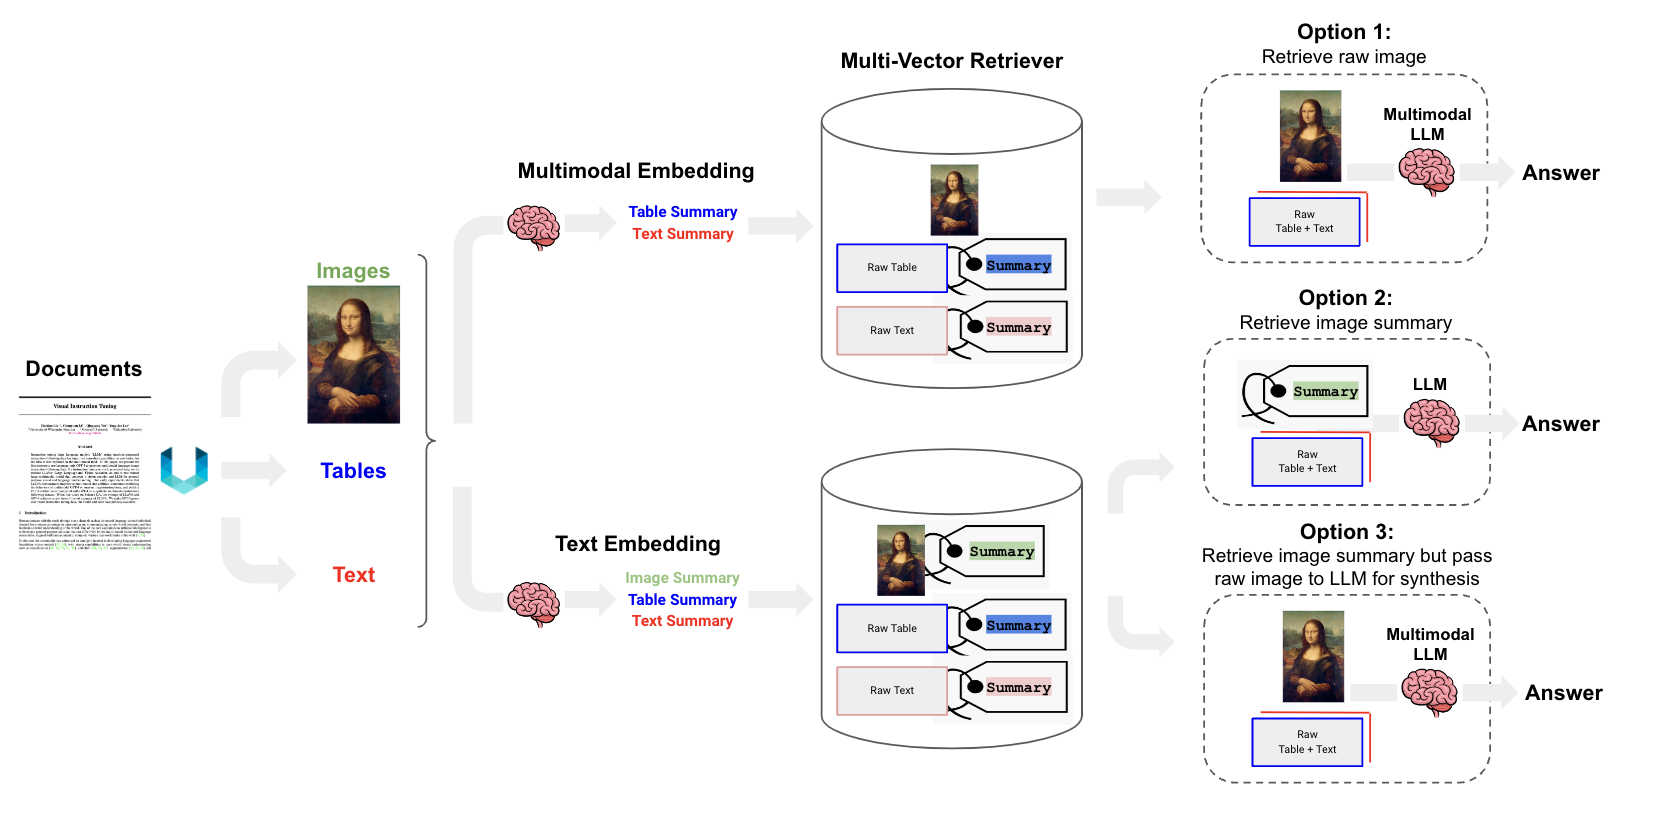

## DEMO Adaptative RAG Runnables

In [ ]:
from services.llm import LLMServices

# Inicializa lo necesario
LLMServices.launch()

In [ ]:
from frank.components.runnables.multimodal_retriever.multimodal_retriever import MultimodalRetriever
from frank.components.runnables.multimodal_generation.multimodal_generation import MultimodalGeneration
from frank.components.runnables.structured_grade_document.structured_grade_document import StructuredGradeDocument
from frank.components.runnables.rewrite_question.rewrite_question import RewriteQuestion

from frank.entity.models.structured_output.grade_documents import GradeDocuments

## RUNNABLES BUILDERS

RETRIEVER_CHAIN = MultimodalRetriever(model=LLMServices.model, vectordb=LLMServices.vectorstore)

GENERARION_CHAIN = MultimodalGeneration(model=LLMServices.model)

GRADE_STRUCTURED_CHAIN = StructuredGradeDocument(model=LLMServices.model, structured_output_schema=GradeDocuments)

REWRITE_CHAIN = RewriteQuestion(model=LLMServices.model)

In [ ]:
# Test raw retriever
raw_retriever = RETRIEVER_CHAIN.get_raw_retriever()
docs = raw_retriever.invoke("In the third chapter of the Pokémon series, what is the name of the Pokémon that was flying in the daytime sky and subsequently caught?")
docs

In [ ]:
from frank.utils.rag.processing import parse_docs, show_base64_image

docs_dict = parse_docs(docs)
show_base64_image(docs_dict['images'][0])

In [ ]:
# Test retriever chain
RETRIEVER_CHAIN.invoke("In the third chapter of the Pokémon series, what is the name of the Pokémon that was flying in the daytime sky and subsequently caught?")

In [ ]:
# Test generation chain
GENERARION_CHAIN.invoke(
    {
        "context": RETRIEVER_CHAIN.invoke("In the third chapter of the Pokémon series, what is the name of the Pokémon that was flying in the daytime sky and subsequently caught?"),
        "question": "In the third chapter of the Pokémon series, what is the name of the Pokémon that was flying in the daytime sky and subsequently caught?"
    }
)

In [ ]:
# Test grade structured chain
GRADE_STRUCTURED_CHAIN.invoke({
        "context": RETRIEVER_CHAIN.invoke("EO!!!"),
        "question": "EO!!!"
    })


In [ ]:
# Test rewrite chain
REWRITE_CHAIN.invoke('who is sleeping?')

# Frank utilities

## DEMO Adaptative RAG

In [ ]:
from frank.workflow_builder import WorkflowBuilder
from frank.config.layouts.adaptative_rag_config_graph import AdaptativeRAGConfigGraph
from frank.entity.models.ragstategraph import RAGState
from frank.utils.common import read_yaml
from frank.utils.logger import setup_logging
from frank.constants import *

## Read the config.yaml
config = read_yaml(CONFIG_FILE_PATH)

## Setup logging Configuration
setup_logging(config)

## Workflow Configuration for the main graph
workflow_builder = WorkflowBuilder(
    config=AdaptativeRAGConfigGraph, 
    state_schema=RAGState,
)
graph = workflow_builder.compile() # compile the graph
# workflow_builder.display_graph(save=True, filepath="artifacts/layouts/adaptative_rag_graph.png") # update the graph artifact

In [ ]:
# Define the input
user_input = "In the third chapter of the Pokémon series, what is the name of the Pokémon that was flying in the daytime sky and subsequently caught?"
message_input = {"messages": [{"role": "human", "content": user_input}]}
await print_process_astream(graph, message_input)

## DEMO OakLang Agent HITL

In [ ]:
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver

from frank.workflow_builder import WorkflowBuilder
from frank.config.layouts.oak_human_loop_config_graph import OakHumanLoopConfigGraph
from frank.entity.models.stategraph import SharedState
from frank.utils.common import read_yaml
from frank.utils.logger import setup_logging
from frank.constants import *

## Read the config.yaml
config = read_yaml(CONFIG_FILE_PATH)

## Setup logging Configuration
setup_logging(config)

## Workflow Configuration for the main graph
workflow_builder = WorkflowBuilder(
    config=OakHumanLoopConfigGraph, 
    state_schema=SharedState, 
    checkpointer=MemorySaver(),
)
graph = workflow_builder.compile() # compile the graph
# workflow_builder.display_graph(save=True, filepath="artifacts/human_graph.png") # update the graph artifact

In [ ]:
# Define the input
user_input = "Hi!"
message_input = {"messages": [{"role": "human", "content": user_input}]}
await print_process_astream(graph, message_input, runnable_config={"configurable": {"thread_id": "001"}})

In [ ]:
# Define the input
user_input = "Could you give me random movements of pickachu, and what is his evolutions?"
message_input = {"messages": [{"role": "human", "content": user_input}]}
await print_process_astream(graph, message_input, runnable_config={"configurable": {"thread_id": "001"},})

In [ ]:
# Define the input
user_input = "Please, give me random movements of that evolution?"
message_input = {"messages": [{"role": "human", "content": user_input}]}
await print_process_astream(graph, message_input, runnable_config={"configurable": {"thread_id": "001"},})

In [ ]:
# Define the input
user_input = "I would like to capture all the pokemon of Ireland"
message_input = {"messages": [{"role": "human", "content": user_input}]}
await print_process_astream(graph, message_input, runnable_config={"configurable": {"thread_id": "002"},})

In [ ]:
# Define the input
message_input = Command(resume={"action": "feedback", 
                                "data": "Sorry, I meant to capture all the pokemon of Iceland... NOT IRELAND"})
await print_process_astream(graph, message_input, runnable_config={"configurable": {"thread_id": "002"},})

In [ ]:
# Define the input
message_input = Command(resume={"action": "continue"})
await print_process_astream(graph, message_input, runnable_config={"configurable": {"thread_id": "002"},})

In [ ]:
# Define the input
user_input = "What is the evolution of feebas?. I would like to capture/dominate all the pokemon of Ireland. By the way... Could you give me random movements of Pikachu?"
message_input = {"messages": [{"role": "human", "content": user_input}]}
await print_process_astream(graph, message_input, runnable_config={"configurable": {"thread_id": "003"},})

In [ ]:
# Define the input
message_input = Command(resume={"action": "continue"})
await print_process_astream(graph, message_input, runnable_config={"configurable": {"thread_id": "003"},})

# Autogen Core + LangGraph

>https://microsoft.github.io/autogen/stable/user-guide/core-user-guide/framework/distributed-agent-runtime.html

>https://microsoft.github.io/autogen/stable/user-guide/core-user-guide/core-concepts/architecture.html

>https://devblogs.microsoft.com/semantic-kernel/semantic-kernel-and-autogen-part-2/

>https://github.com/Azure-Samples/az-ai-kickstarter


#### How Runtime AutoGen works
A distributed runtime, as shown in the diagram above, consists of a host servicer and multiple workers. The host servicer facilitates communication between agents across workers and maintains the states of connections. The workers run agents and communicate with the host servicer via gateways. They advertise to the host servicer the agents they run and manage the agents’ lifecycles.

Agents work the same way as in the standalone runtime so that developers can switch between the two runtime types with no change to their agent implementation.

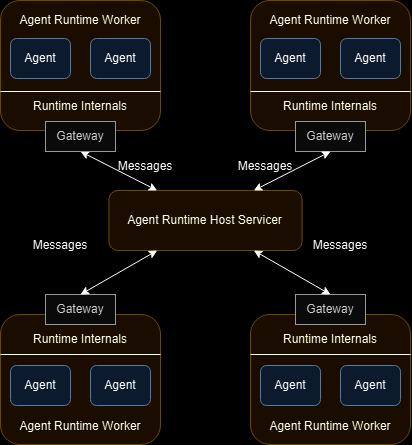


#### Shared Runtime Semantic-Kernel and Autogen

A central design goal of this convergence effort is the adoption of a common runtime and interfaces. By aligning the execution model, both frameworks can leverage shared abstractions for agent orchestration and process management.

Semantic Kernel is adding connectors to support integrating agents from other services and libraries (such as OpenAI Assistant agent and Azure AI Agents) and now, with AutoGen agents

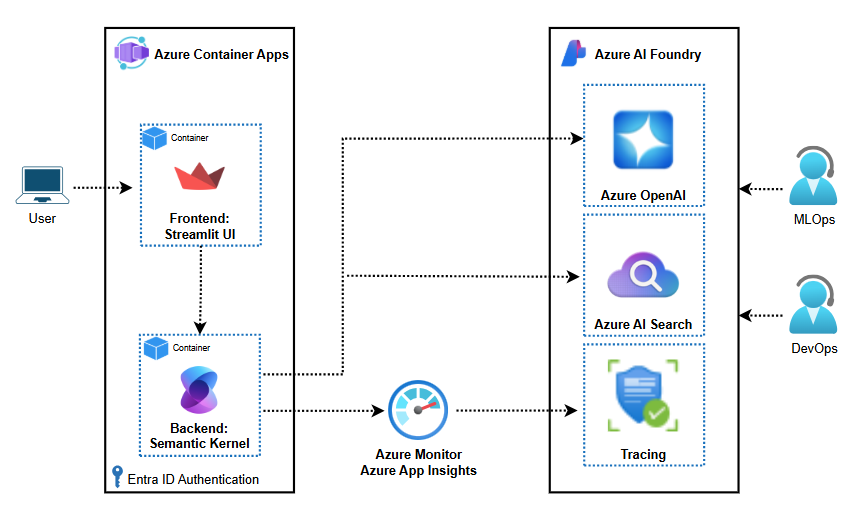


## Autogen + OakLang Agent HITL + OpenTelemetry Tracing Azure AI Foundry 

In [ ]:
### Azure AI Inference Tracer
import os
from langchain_azure_ai.callbacks.tracers import AzureAIInferenceTracer

## MANAGE IDENTITY INSTEAD ENV
# from azure.ai.projects import AIProjectClient
# from azure.identity import DefaultAzureCredential # NOTE USE ASYNC DEFAULT CREDENTIALS

# project_client = AIProjectClient.from_connection_string(
#     credential=DefaultAzureCredential(),
#     conn_str="<your-project-connection-string>",
# )

## Runnable_Config + Langchain Tracer
langchain_tracer = AzureAIInferenceTracer(
    connection_string=os.environ["AZURE_APP_INSIGHT_CONNECTION_STRING"], # project_client.telemetry.get_connection_string()
    enable_content_recording=True,
)

runnable_config = {
    "configurable": {"thread_id": "004"}, 
    "callbacks": [langchain_tracer]}

### AUTOGEN WRAPPER
from autogen_core import SingleThreadedAgentRuntime, AgentId
from frank.utils.autogen.langgraph_message_wrapper import LangGraphToolUseAgent, MessageWrapperAutogenState

runtime = SingleThreadedAgentRuntime()
await LangGraphToolUseAgent.register(
    runtime,
    "Frak-OakLang-Agent",
    lambda: LangGraphToolUseAgent(
        description="Tool to use OakLang Agent Assistant",
        graph=graph,
        runnable_config=runnable_config
    ),
)
agent = AgentId("Frak-OakLang-Agent", key="default")

# Start the runtime
runtime.start()

# Example with regular message
response = await runtime.send_message(
    MessageWrapperAutogenState(content="What is the evolution of feebas? could you give me random movements of his evolution?"),
    agent
)
# Stop the runtime
await runtime.stop()

In [ ]:
response.content

In [ ]:
for event in response.events:
    print(event)
    print("\n")

# 🤖 LangGraph + AutoGen: Resumen

## 🧠 ¿Qué aporta cada uno?

### 📘 Ventajas de usar AutoGen con LangGraph

**AutoGen destaca por:**
- Gestión de múltiples agentes con roles definidos (`user_proxy`, `assistant`, `coder`, `critic`, etc.).
- Supervisor integrado para coordinar agentes automáticamente.
- Soporte para memoria, múltiples rondas y auto-detención.
- Ideal como "orquestadora" de agentes sobre un backend.

**LangGraph destaca por:**
- Flujos **determinísticos y controlables** mediante nodos y condiciones.
- Ideal para workflows estructurados, decisiones condicionales y visualización.
- Cada nodo puede representar un paso lógico o un agente.

## 🧩 Supervisor vs Orquestador de Agentes 

### 💡 ¿Cuál es la diferencia?

| Rol            | ¿Qué hace?                                                                 | Nivel                   | Equivalente humano                   |
|----------------|-----------------------------------------------------------------------------|--------------------------|--------------------------------------|
| **Supervisor** | Evalúa resultados, valida decisiones, interviene si algo sale mal.         | Operativo     | Jefe de equipo que revisa entregas   |
| **Orquestador**| Decide qué agentes participan, cuándo, en qué orden y cómo se comunican.   | Estrarégico | Director de proyecto                 |


### 📌 Key Points

- El **supervisor** suele ser un **agente dentro del sistema**, que actúa como evaluador o controlador de calidad.
- El **orquestador** es responsable de **diseñar y controlar el flujo general** de la interacción entre agentes.

---

## ¿Dónde es mejor ubicar un **supervisor**?

### Opción 1: **Supervisor en AutoGen**

**✅ Ventajas:**
- Supervisión reflexiva integrada de forma predeterminada.
- Maneja colaboración dinámica entre agentes sin necesidad de lógica explícita.
- Facilita la comunicación natural tipo "chat" entre múltiples agentes.

**❌ Contras:**
- Menor previsibilidad del flujo en entornos de producción controlada.
- Difícil de representar, visualizar, predecir o auditar paso a paso.

### Opción 2: **Supervisor en LangGraph**

**✅ Ventajas:**
- Control total del flujo, decisiones, loops, human review y routing.
- Ideal para despliegues críticos, donde la trazabilidad es clave.
- Fácil de visualizar y depurar.

**❌ Contras:**
- Tienes que codificar la lógica supervisora manualmente.
- Menos dinámico y espontaneidad en colaboración espontánea e interacción entre agentes.

---

## 🚀 ¿Qué hacer si quiero agentes personalizados con alta trazabilidad y un supervisor a medida?

### 🛠️ LangGraph como estructura de agentes
- Cada grafo es una tool con lógica definida.
- Ideal para sistemas robustos y predecibles.
- Mejor para funciones deterministas o tareas bien definidas.

### 🤝 AutoGen como coordinador de alto nivel

- AutoGen se encarga del flujo y supervisión.
- Dentro de cada agente, puedes usar LangGraph para definir su comportamiento interno.
- Ventajoso para casos donde la colaboración multiagentes requiere razonamiento fluido.

---

### 📌 Key Points

- Usa **AutoGen** si priorizas **colaboración natural, reflexiva y automatizada**.
- Usa **LangGraph** si quieres **control total del flujo y reglas personalizadas**.
- Para lo mejor de ambos mundos **combina LangGraph como tools complejas + AutoGen como capa de razonamiento y coordinación dinámica (supervisor).** Se empleará AutoGen para coordinación dinámica y razonamiento, mientras defines el comportamiento interno de cada agente con LangGraph.

# Put ALL Together: 
## OakLang Agent HITL + Adaptative/AGENTIC RAG + Tracing Azure AI Foundry Opentelemetry

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

from frank.workflow_builder import WorkflowBuilder
from frank.config.layouts.adaptative_rag_config_graph import AdaptativeRAGConfigGraph
from frank.config.layouts.oak_human_loop_config_graph import OakHumanLoopConfigGraph
from frank.entity.models.ragstategraph import RAGState
from frank.entity.models.stategraph import SharedState
from frank.utils.common import read_yaml
from frank.utils.logger import setup_logging
from frank.constants import *

## Read the config.yaml
config = read_yaml(CONFIG_FILE_PATH)

## Setup logging Configuration
setup_logging(config)

## Workflow Configuration for the main graph
workflow_builder = WorkflowBuilder(
    config=AdaptativeRAGConfigGraph, 
    state_schema=RAGState,
)
ADAPTATIVE_RAG_GRAPH = workflow_builder.compile() # compile the graph

## Workflow Configuration for the main graph
workflow_builder = WorkflowBuilder(
    config=OakHumanLoopConfigGraph, 
    state_schema=SharedState,
)
OAKLANG_AGENT_GRAPH = workflow_builder.compile() # compile the graph


## Agents/Graphs as tools

In [ ]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

from services.llm import LLMServices

LLMServices.launch()

@tool
async def oaklang_agent_tool(input: str) -> str:
    """Tool to get the evolution or random movements or certain Pokémon. The input is a question."""
    message_input = {"messages": [{"role": "human", "content": input}]}
    response = await OAKLANG_AGENT_GRAPH.ainvoke(message_input, {"configurable": {"thread_id": '001'}})
    return response['messages'][-1].content

@tool
async def adaptive_rag_tool(input: str) -> str:
    """Tool to use RAG about Pokémon series questions. The input is a question."""
    message_input = {"messages": [{"role": "human", "content": input}]}
    response = await ADAPTATIVE_RAG_GRAPH.ainvoke(message_input)
    return response['messages'][-1].content

tools = [oaklang_agent_tool, adaptive_rag_tool]

agent_executor = create_react_agent(model = LLMServices.model, tools=tools, prompt="You are an agent that can route into tools")

async def main():
    return await agent_executor.ainvoke({
        "messages": [{
            "role": "user",
            "content": "In the third chapter of the Pokémon series, what is the name of the Pokémon that was flying in the daytime sky and subsequently caught? and what is the evolution of that pokemon?"
        }]
    })

response = await main()


In [ ]:
response["messages"][-1].content

## Agents/Graphs as MCP tools